In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import folium
from folium.plugins import HeatMap
from textblob import TextBlob

In [2]:
#Loading and preprocessing data
data = pd.read_csv('/kaggle/input/homestays/Homestays_Data(in).csv')

In [3]:
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [5]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


 # **1. Feature Engineering**

In [ ]:
#Creating host_tenure feature, providing a measure of host experience. 
data['host_since'] = pd.to_datetime(data['host_since'])
data['Host_Tenure'] = (datetime.now() - data['host_since']).dt.days / 365.00

In [6]:
#Creating Host_Tenure, providing a measure of host experience
data['host_since'] = pd.to_datetime(data['host_since'])
data['Host_Tenure'] = (datetime.now() - data['host_since']).dt.days / 365.25

In [7]:
#Amenities_count, quantify the property offerings
data['Amenities_count'] = data['amenities'].apply(lambda x: len(x.split(',')))

In [8]:
#Adding Days_Since_Last_Review in order to assess listing activity and relevance
data['last_review'] = pd.to_datetime(data['last_review'])
data['Days_Since_Last_Review'] = (datetime.now() - data['last_review']).dt.days

In [9]:
data.dropna()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,Host_Tenure,Amenities_count,Days_Since_Last_Review
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,6.885695,15,2419.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,7.534565,19,2428.0
5,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,...,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0,6.918549,10,2437.0
7,13971273,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,...,Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1.0,1.0,10.973306,26,2583.0
8,180792,4.787492,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",2,1.0,Real Bed,moderate,True,...,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0,8.928131,21,2418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74102,7935934,4.110874,Villa,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",10,3.0,Real Bed,flexible,False,...,West Hills,1,80.0,https://a0.muscache.com/im/pictures/27fea634-a...,91307,1.0,10.0,10.852841,22,2684.0
74103,11829011,5.135798,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,moderate,True,...,Union Square,24,98.0,https://a0.muscache.com/im/pictures/9a99e2de-c...,94108,1.0,1.0,12.616016,24,3099.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0,8.013689,16,2580.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206,2.0,2.0,12.339493,31,2432.0


# **2. Exploratory Data Analysis (EDA)**

In [10]:
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'Host_Tenure', 'Amenities_count', 'Days_Since_Last_Review'],
      dtype='object')

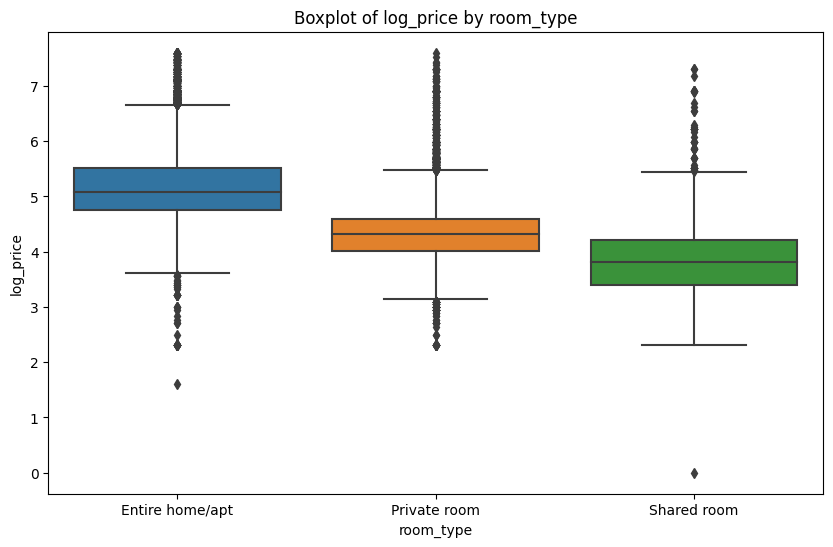

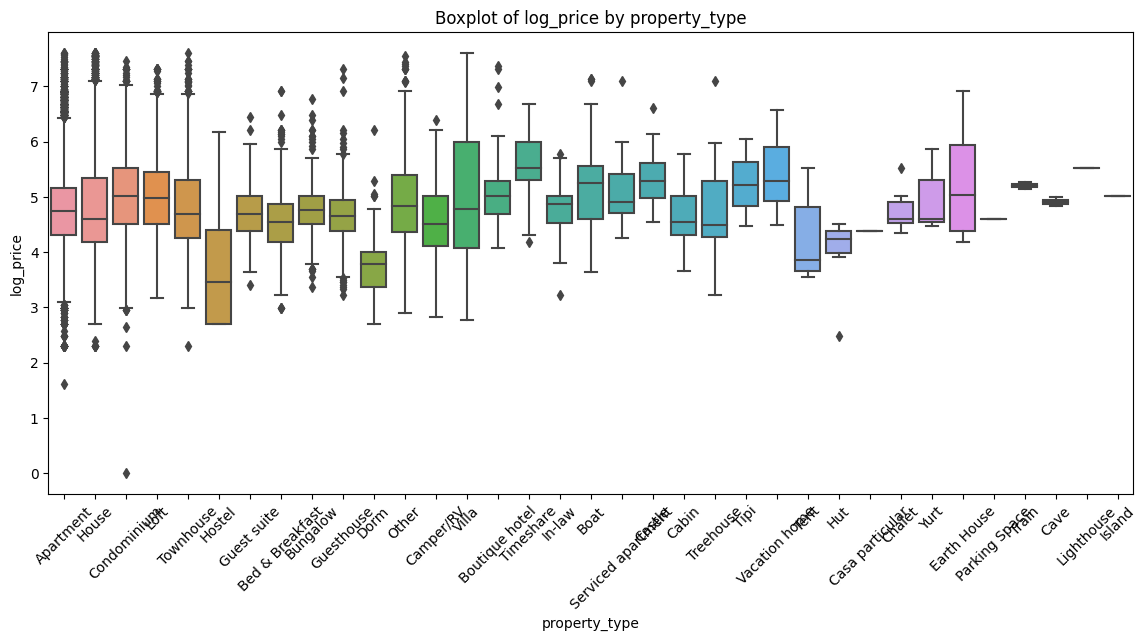

In [11]:
# Boxplot for log_price across different room types
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='log_price', data=data)
plt.title("Boxplot of log_price by room_type")
plt.show()

# Boxplot for log_price across different property types
plt.figure(figsize=(14, 6))
sns.boxplot(x='property_type', y='log_price', data=data)
plt.title("Boxplot of log_price by property_type")
plt.xticks(rotation=45)
plt.show()


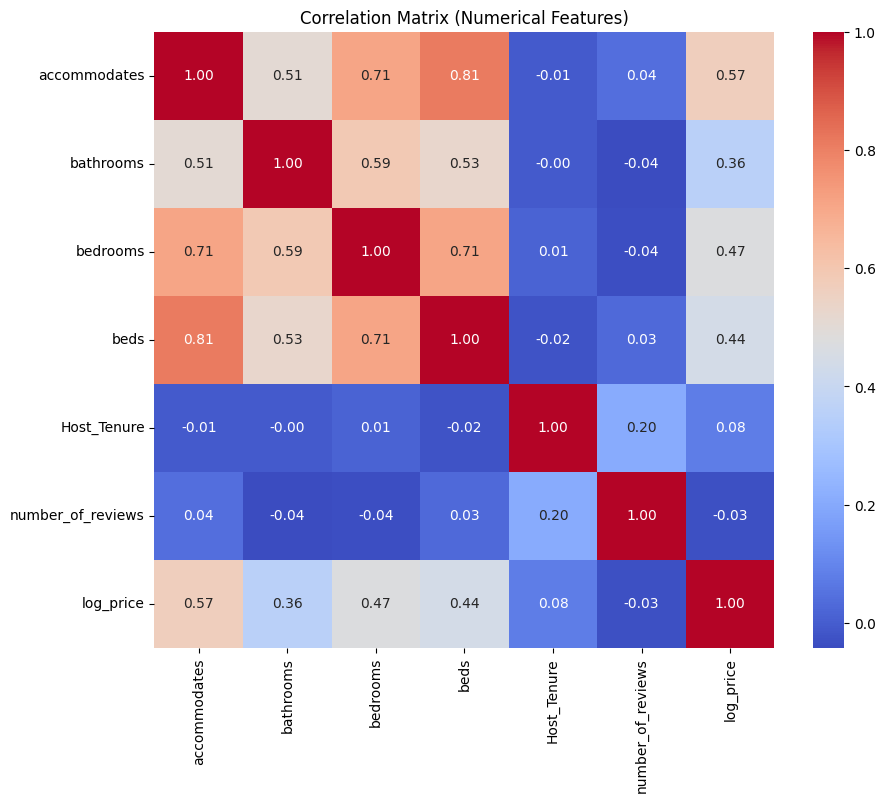

In [12]:
# Correlation Matrix for the modified dataset
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Host_Tenure', 'number_of_reviews', 'log_price']
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()


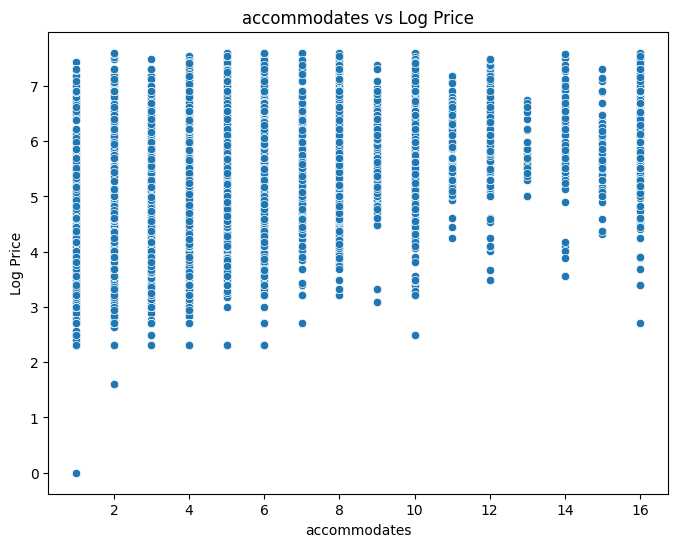

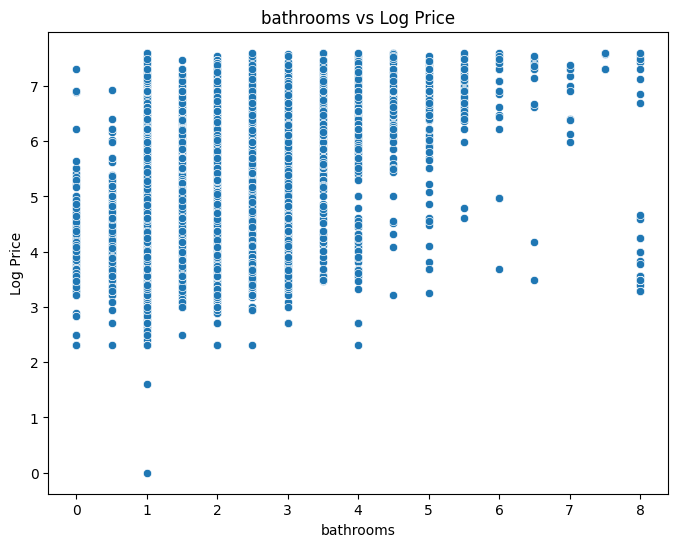

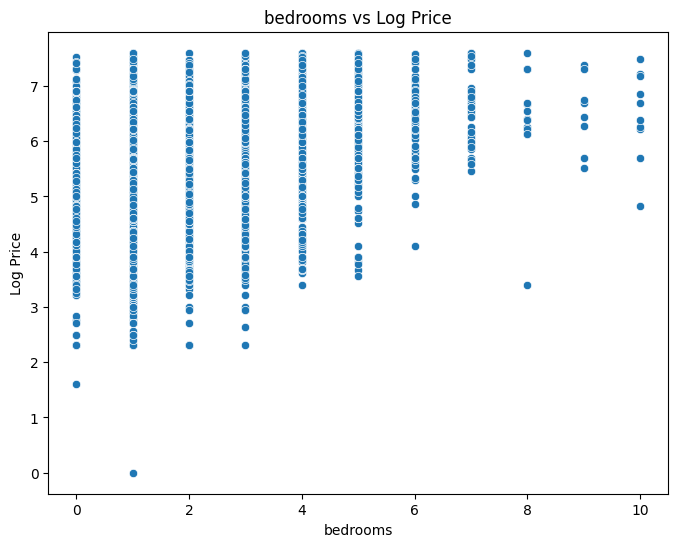

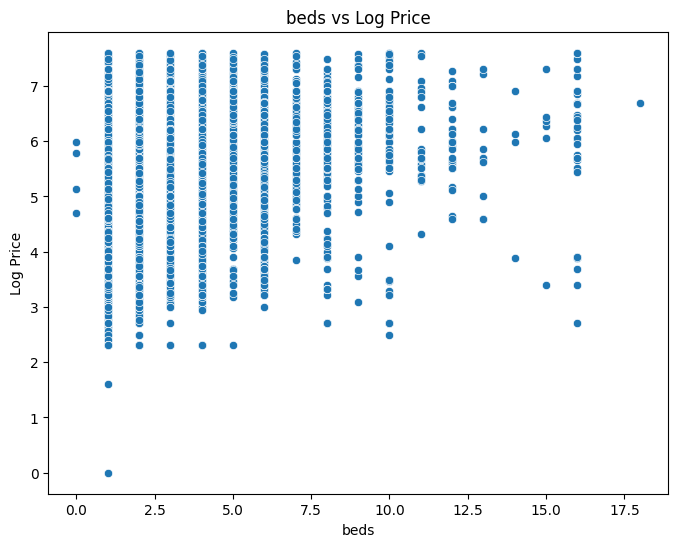

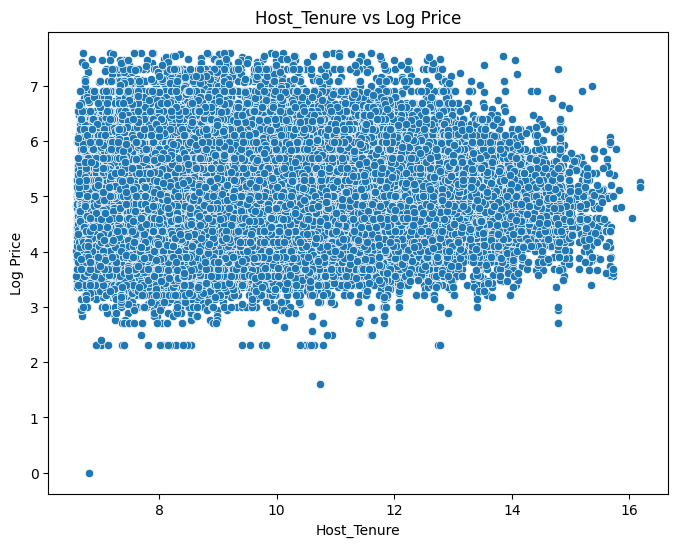

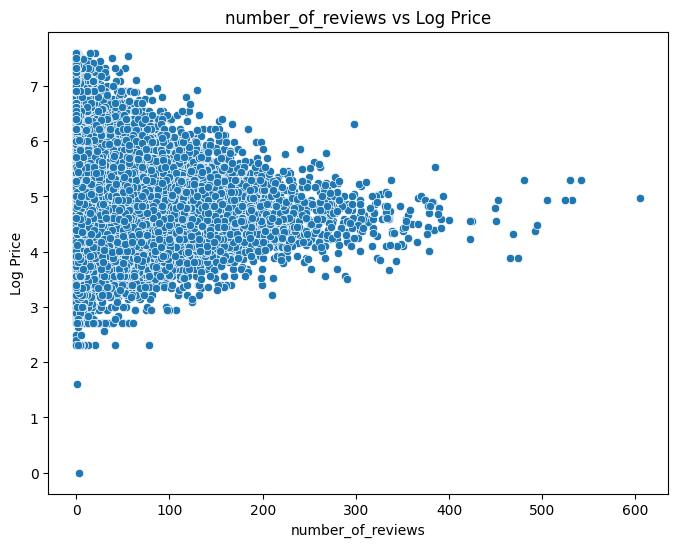

In [13]:
# Scatter plots to explore relationships between variables.

for feature in numerical_cols[:-1]: 
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=feature, y='log_price')
    plt.title(f'{feature} vs Log Price')
    plt.xlabel(feature)
    plt.ylabel('Log Price')
    plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


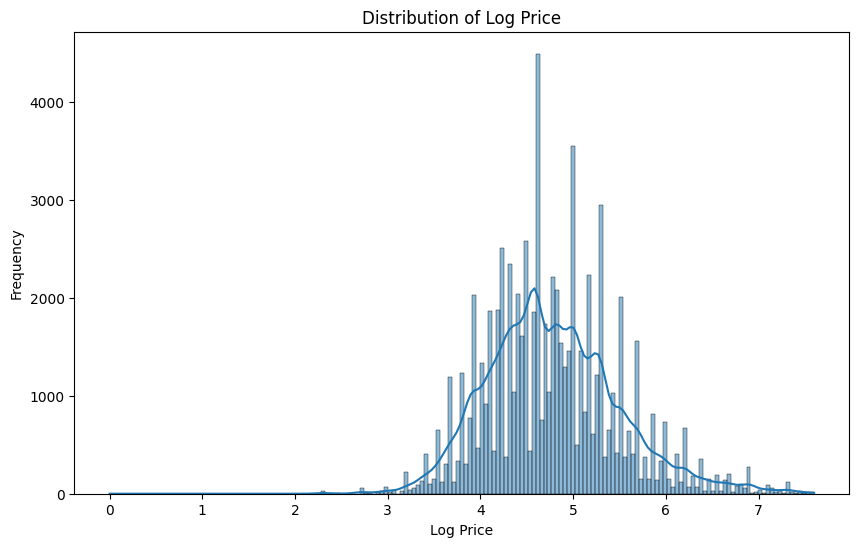

In [14]:
# Histogram for distribution analysis
plt.figure(figsize=(10, 6))
sns.histplot(data['log_price'], kde=True)
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

# **3. Geospatial Analysis**

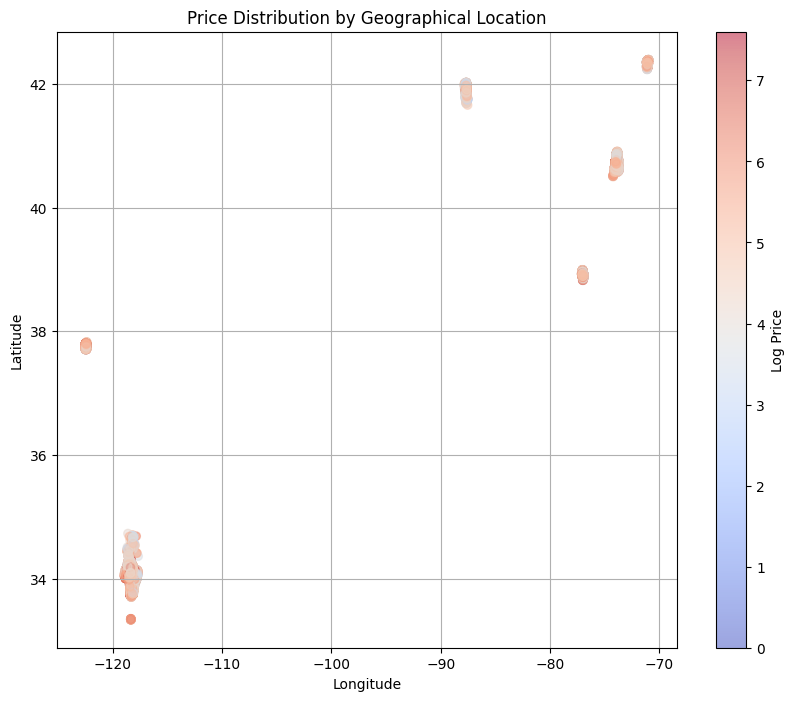

In [15]:
mean_lat = data['latitude'].mean()
mean_lon = data['longitude'].mean()
homestay_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Adding markers for each listing
for index, row in data.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(homestay_map)

# Save the map as an HTML file
homestay_map.save("homestay_listings_map.html")

# Visually assessing price distribution
plt.figure(figsize=(10, 8))
plt.scatter(data['longitude'], data['latitude'], c=data['log_price'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Log Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Price Distribution by Geographical Location')
plt.grid(True)
plt.show()

# **4. Sentiment Analysis on Textual Data**

In [16]:
def calculate_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

# Apply sentiment analysis to the description column
data['description_sentiment'] = data['description'].apply(calculate_sentiment)


In [17]:
data[['description', 'description_sentiment']].head()

,description,description_sentiment
0,"Beautiful, sunlit brownstone 1-bedroom in the ...",0.716667
1,Enjoy travelling during your stay in Manhattan...,0.250000
2,The Oasis comes complete with a full backyard ...,0.274085
3,This light-filled home-away-from-home is super...,0.281515
4,"Cool, cozy, and comfortable studio located in ...",0.196795


In [18]:
positive_sentiments = data[data['description_sentiment'] >= 0]
positive_sentiments[['description_sentiment','description']]

,description_sentiment,description
0,0.716667,"Beautiful, sunlit brownstone 1-bedroom in the ..."
1,0.250000,Enjoy travelling during your stay in Manhattan...
2,0.274085,The Oasis comes complete with a full backyard ...
3,0.281515,This light-filled home-away-from-home is super...
4,0.196795,"Cool, cozy, and comfortable studio located in ..."
...,...,...
74106,0.600000,one room in bushwick apt
74107,0.174256,"Located on the Pacific Coast Highway, this apa..."
74108,0.229167,A modern apartment located in East Williamsbur...
74109,0.320370,"Fully renovated, designer's studio located in ..."


In [20]:
negative_sentiments = data[data['description_sentiment']< 0]
negative_sentiments[['description_sentiment','description']]

,description_sentiment,description
53,-0.025000,his apartment in exceptionally clean from head...
375,-0.079365,Private room and bath in single family house l...
417,-0.071429,single traveler
444,-0.096429,"near BC shuttle, supermarket and several cafe...."
566,-0.183333,"DPS Patrolled Area, Quiet Neighborhood occupie..."
...,...,...
73758,-0.051852,Spacious 1 bedroom apartment in the heart of A...
73824,-0.000260,Spacious bedroom in spacious brownstone. Close...
73850,-0.023810,Big private room with queen bed in Upper Manha...
73858,-0.037500,Our apartment is a cozy little 3 bed/1 bath in...


# **5. Amenities Analysis**

In [21]:
data.info

<bound method DataFrame.info of              id  log_price property_type        room_type  \
0       6901257   5.010635     Apartment  Entire home/apt   
1       6304928   5.129899     Apartment  Entire home/apt   
2       7919400   4.976734     Apartment  Entire home/apt   
3      13418779   6.620073         House  Entire home/apt   
4       3808709   4.744932     Apartment  Entire home/apt   
...         ...        ...           ...              ...   
74106  14549287   4.605170     Apartment     Private room   
74107  13281809   5.043425     Apartment  Entire home/apt   
74108  18688039   5.220356     Apartment  Entire home/apt   
74109  17045948   5.273000     Apartment  Entire home/apt   
74110   3534845   4.852030          Boat  Entire home/apt   

                                               amenities  accommodates  \
0      {"Wireless Internet","Air conditioning",Kitche...             3   
1      {"Wireless Internet","Air conditioning",Kitche...             7   
2      {TV,"C

In [22]:
# Convert 'amenities' column to string format
data['amenities'] = data['amenities'].astype(str)

# Split the amenities into individual items
data['amenities'] = data['amenities'].apply(lambda x: x.replace('{', '').replace('}', '').replace('"', '').split(','))

# Create a new DataFrame with amenities as binary features
amenities_df = pd.get_dummies(data['amenities'].apply(pd.Series).stack()).sum(axis=0)

# Concatenate the new DataFrame with the original data
data = pd.concat([data, amenities_df], axis=1)

# Drop the original 'amenities' column
data.drop(columns=['amenities'], inplace=True)

# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(exclude=['float', 'int']).columns

# Drop non-numeric columns from the correlation analysis
data_numeric = data.drop(columns=non_numeric_cols)

# Compute correlation between amenities and log_price
amenities_corr = data_numeric.corr()['log_price'].sort_values(ascending=False)


In [23]:
print("Top 10 amenities positively correlated with log_price:")
amenities_corr.head(10)

Top 10 amenities positively correlated with log_price:


log_price                 1.000000
accommodates              0.567574
bedrooms                  0.473212
beds                      0.442153
bathrooms                 0.355420
Amenities_count           0.194528
review_scores_rating      0.091219
Host_Tenure               0.078333
description_sentiment     0.075808
Days_Since_Last_Review    0.021550
Name: log_price, dtype: float64

In [24]:
print("Top 10 amenities negatively correlated with log_price:")
amenities_corr.tail(10)

Top 10 amenities negatively correlated with log_price:


Amenities_count           0.194528
review_scores_rating      0.091219
Host_Tenure               0.078333
description_sentiment     0.075808
Days_Since_Last_Review    0.021550
latitude                 -0.002193
id                       -0.007178
number_of_reviews        -0.032470
longitude                -0.047529
0                              NaN
Name: log_price, dtype: float64

# **6. Categorical Data Encoding**

In [25]:
# Identify categorical variables
categorical_cols = ['room_type', 'city', 'property_type','cancellation_policy']

# Apply one-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the encoded DataFrame
print(data.head())

           id  log_price  accommodates  bathrooms  bed_type cleaning_fee  \
0   6901257.0   5.010635           3.0        1.0  Real Bed         True   
1   6304928.0   5.129899           7.0        1.0  Real Bed         True   
2   7919400.0   4.976734           5.0        1.0  Real Bed         True   
3  13418779.0   6.620073           4.0        1.0  Real Bed         True   
4   3808709.0   4.744932           2.0        1.0  Real Bed         True   

                                         description first_review  \
0  Beautiful, sunlit brownstone 1-bedroom in the ...    6/18/2016   
1  Enjoy travelling during your stay in Manhattan...     8/5/2017   
2  The Oasis comes complete with a full backyard ...    4/30/2017   
3  This light-filled home-away-from-home is super...          NaN   
4  Cool, cozy, and comfortable studio located in ...    5/12/2015   

  host_has_profile_pic host_identity_verified  ... property_type_Townhouse  \
0                    t                      t  ...

# **7. Model Development and Training**

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74242 entries, 0 to translation missing: en.hosting_amenity_50
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   74111 non-null  float64       
 1   log_price                            74111 non-null  float64       
 2   accommodates                         74111 non-null  float64       
 3   bathrooms                            73911 non-null  float64       
 4   bed_type                             74111 non-null  object        
 5   cleaning_fee                         74111 non-null  object        
 6   description                          74111 non-null  object        
 7   first_review                         58247 non-null  object        
 8   host_has_profile_pic                 73923 non-null  object        
 9   host_identity_verified               73923 non-null

In [34]:
from sklearn.impute import SimpleImputer

In [38]:
# Filter float columns
float_columns = data.select_dtypes(include=['float']).columns

# Filter data to include only float columns
data_float = data[float_columns]

# Convert column names to string
data_float.columns = data_float.columns.astype(str)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Impute missing values in target variable
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data into features (X) and target variable (y)
X = data_float.drop(columns=['log_price'])
y = data_float['log_price']
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)


In [39]:
X

,id,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,Host_Tenure,Amenities_count,Days_Since_Last_Review,description_sentiment,0
0,6901257.0,3.0,1.0,40.696524,-73.991617,2.0,100.0,1.0,1.0,12.117728,9.0,2851.0,0.716667,NaN
1,6304928.0,7.0,1.0,40.766115,-73.989040,6.0,93.0,3.0,3.0,6.885695,15.0,2419.0,0.250000,NaN
2,7919400.0,5.0,1.0,40.808110,-73.943756,10.0,92.0,1.0,3.0,7.534565,19.0,2428.0,0.274085,NaN
3,13418779.0,4.0,1.0,37.772004,-122.431619,0.0,NaN,2.0,2.0,9.054073,15.0,NaN,0.281515,NaN
4,3808709.0,2.0,1.0,38.925627,-77.034596,4.0,40.0,0.0,1.0,9.188227,12.0,2663.0,0.196795,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wide hallway clearance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,475.0
Window guards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,615.0
Wireless Internet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71265.0
translation missing: en.hosting_amenity_49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20427.0


In [ ]:
# bool_columns = ['host_has_profile_pic', 'host_identity_verified', 'cleaning_fee']
# data[bool_columns] = data[bool_columns].replace({'t': 1, 'f': 0})

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Baseline: Simple Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_pred = linear_reg.predict(X_test)
linear_reg_mse = mean_squared_error(y_test, linear_reg_pred)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_pred)
print("Linear Regression MSE:", linear_reg_mse)
print("Linear Regression MAE:", linear_reg_mae)


Linear Regression MSE: 0.3268605623815285
Linear Regression MAE: 0.43675990370464046


In [42]:
# RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
random_forest_mae = mean_absolute_error(y_test, random_forest_pred)
print("Random Forest MSE:", random_forest_mse)
print("Random Forest MAE:", random_forest_mae)

Random Forest MSE: 0.18823379867461193
Random Forest MAE: 0.3172840868293228


# **8. Model Optimization and Validation**

In [44]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [ ]:
# Performing grid search with k-fold cross-validation for RandomForestRegressor
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
rf_predictions = rf_best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Random Forest Best Model Mean Squared Error:", rf_mse)

In [ ]:
# Performing grid search with k-fold cross-validation for GradientBoostingRegressor
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train, y_train)
gb_best_model = gb_grid_search.best_estimator_
gb_predictions = gb_best_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_predictions)
print("Gradient Boosting Best Model Mean Squared Error:", gb_mse)

# **9. Feature Importance and Model Insights**

In [ ]:
rf_feature_importances = pd.DataFrame({'Feature': features, 'Importance': random_forest.feature_importances_})
print("Random Forest Feature Importances:")
print(rf_feature_importances)

In [ ]:
gb_model = GradientBoostingRegressor(random_state=40)
gb_model.fit(X_train, y_train)

In [ ]:
gb_feature_importances = pd.DataFrame({'Feature': features, 'Importance': gb_model.feature_importances_})
print("\nGradient Boosting Feature Importances:")
print(gb_feature_importances)

In [ ]:
# Using SHAP values for RandomForestRegressor
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train)

In [ ]:
# Visualizing SHAP values
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=features)


# **10. Predictive Performance Assessment**

In [ ]:
# Make predictions on the test set using the final model
final_model_predictions = rf_model.predict(X_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, final_model_predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(y_test, final_model_predictions)
print("R-squared (R²):", r2)

# Analyze residuals
residuals = y_test - final_model_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(final_model_predictions, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
linear_reg_pred = linear_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, linear_reg_pred))
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
r2 = r2_score(y_test, linear_reg_pred)
print("R-squared (R2):", r2)

In [ ]:
# Analyzing residuals
residuals = y_test - linear_reg_pred
